# Analiza częstotliwościowa sygnału


## 1. Wykres sygnału w dziedzinie czasu
Rysowanie wykresu sygnału w dziedzinie czasu, podobnie jak w projekcie 1.

In [283]:
import librosa
import librosa.display
import scipy as sp
import IPython.display as ipd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import math
from enum import Enum

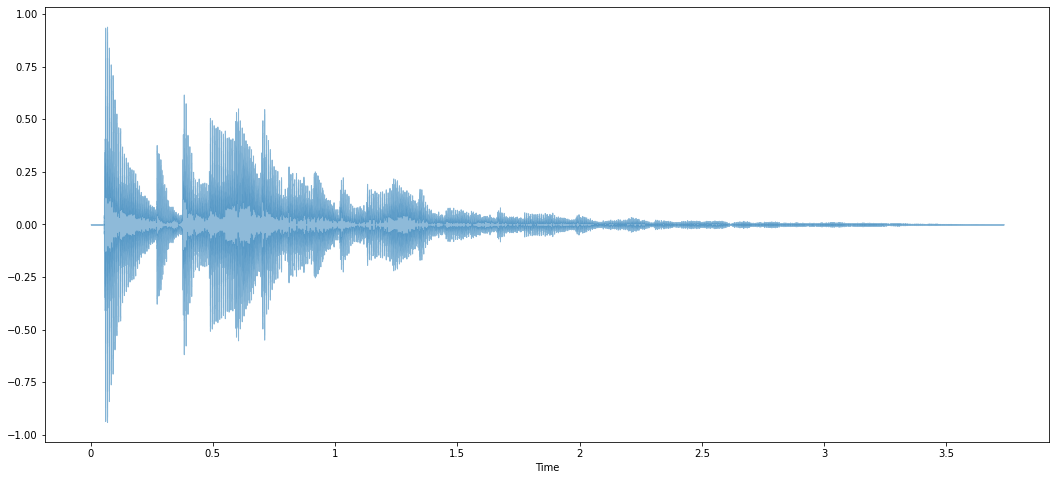

In [284]:
audiopath = "./audio/melody.wav"
signal, sr = librosa.load(audiopath)
plt.figure(figsize=(18,8))
librosa.display.waveshow(signal, sr=sr, alpha=0.5)

## 2. Funkcje okienkowe
* Zastosowanie na ramce/sygnale funkcji okienkowej i narysowanie
wykresu w dziedzinie czasu, oraz w dziedzinie częstotliwości po zastosowaniu
okna.
* Wybór funkcji okienkowych:
    * okno prostokątne
    * okno Hamminga
    * okno van Hanna

In [285]:
FRAME_SIZE = 2048
HOP_SIZE = 512
duration = librosa.get_duration(y=signal,sr=sr)
frames = librosa.util.frame(signal, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)
_,FRAME_NUM = frames.shape

def get_frame(ind):
    return frames[:,ind]

def frame_timespan (ind, duration, sr):
    beg = (ind*HOP_SIZE)/sr
    end = (ind*HOP_SIZE+FRAME_SIZE)/sr
    frame_tsp = np.linspace(beg,end,FRAME_SIZE)
    return frame_tsp

def magn(frame):
    ft = sp.fft.fft(frame) # widmo
    magnitude = np.absolute(ft) # apmlituda
    return magnitude

def frame_frequencies (ind, sr):
    frame = get_frame(ind)
    frame_freq = np.linspace(0, sr, len(magn(frame)))
    return frame_freq

def frame_wind_plot(ind, duration, sr):
    frame = get_frame(ind)
    timespan = frame_timespan(ind, duration, sr)
    
    frame_len = FRAME_SIZE
    hamming = frame*np.hamming(frame_len)
    hann = frame*np.hanning(frame_len)
    plt.figure(figsize=(25,10))
    
    plt.subplot(2,1,1)
    plt.plot(timespan,frame)
    plt.plot(timespan,hamming,color='r')
    plt.legend(['Hamminga'])
    
    plt.plot(timespan,hann,color='g')
    plt.legend(['von Hanna'])
    
    plt.title(f"Ramka {ind}")
    plt.legend(['prostokątne','Hamminga','von Hanna'])
    plt.ylabel("Amplituda")
    plt.xlabel("Czas [s]")
    
    freq = frame_frequencies(ind,sr)
    
    plt.subplot(2,1,2)
    plt.plot(freq,magn(frame),color='g')
    plt.plot(freq,magn(hamming),color='r')
    plt.plot(freq,magn(hann),color='b')
    plt.ylabel("Amplituda")
    plt.xlabel("Częstotliwość [Hz]")


### 2.1. Wykresy ramek po zastosowaniu okna

wybierz ramkę z przedziału [0,156]: 5


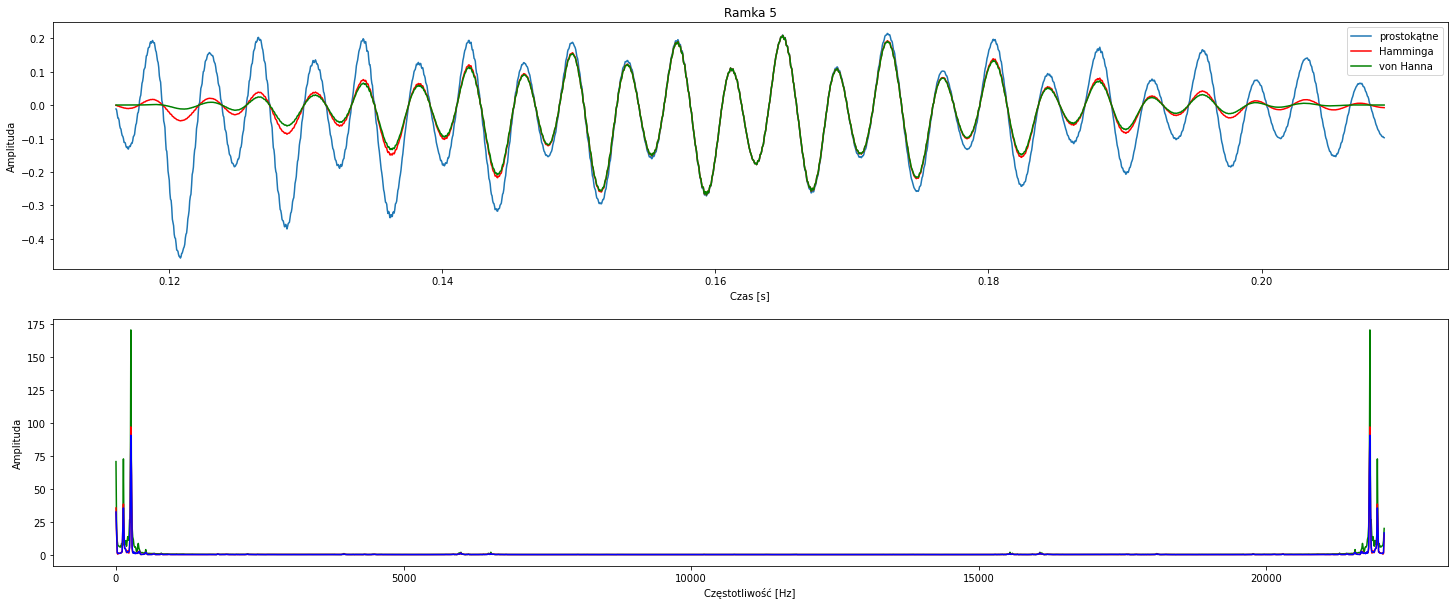

In [286]:
ind = int(input(f"wybierz ramkę z przedziału [0,{FRAME_NUM-1}]: "))
frame_wind_plot(ind,duration,sr)


## 3. Widmo amplitudowe
Rysowanie wykresu widma częstotliwościowego poprzez zastosowanie FFT
* można użyć biblioteki do FFT,
* lub zrobić FFT od podstaw samemu (na wyżej niż 4.0)
dla całego sygnału lub dla konkretnej ramki sygnału o dowolnej długości,
niekoniecznie ramki początkowej.

### Na całym sygnale

In [287]:
def plotSpectr(signal,sr,title,color="tab:blue",showAxes=True):
    ft = sp.fft.fft(signal) # widmo
    magnitude = np.absolute(ft) # apmlituda
    frequency = np.linspace(0, sr, len(magnitude))
    freq = [f for f in frequency if f<=sr/2]
    lim = len(freq)
    plt.plot(frequency[:lim], magnitude[:lim],color=color)
    if showAxes == True:
        plt.xlabel("Częstotliwość [Hz]")
        plt.ylabel("Amplituda")
    plt.title(title)

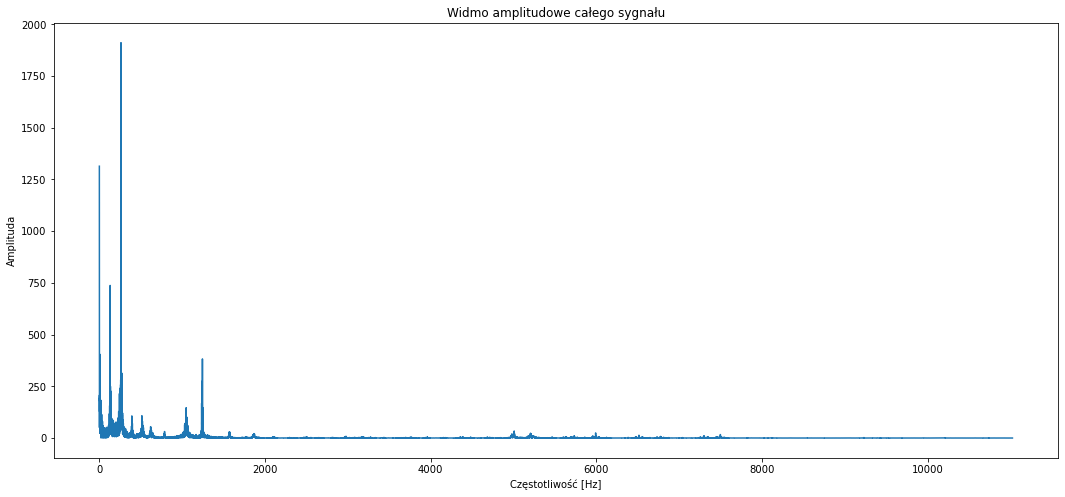

In [288]:
plt.figure(figsize=(18,8))
plotSpectr(signal,sr,"Widmo amplitudowe całego sygnału")
plt.show()

## 4. Spektogram
Rysowanie spektrogramu (implementacja samodzielna) z możliwością wyboru
(na wyżej niż 4.0)
* okna
* długości ramki
* nakładania ramek – overlap

In [289]:
class WindowType(Enum):
    RECT = 1
    HAMM = 2
    HANN = 3
        
def spec_plot(signal, frame_type, frame_length, hop_length, y_axis="linear", title="", sr=sr, logAmp=False):
    
    if frame_type == WindowType.HANN:
        S = librosa.stft(signal, n_fft=frame_length, window = sp.signal.windows.hann,  hop_length=hop_length)
    elif frame_type == WindowType.HAMM:
        S = librosa.stft(signal, n_fft=frame_length, window = sp.signal.windows.hamming,  hop_length=hop_length)
    else:
        S = librosa.stft(signal, n_fft=frame_length, window = np.ones(frame_length) , hop_length=hop_length)
    
    Y = np.abs(S)**2
    if logAmp:
        Y =librosa.power_to_db(Y)
        
    plt.figure(figsize=(25, 10))
    librosa.display.specshow(Y, 
                             sr=sr, 
                             hop_length=hop_length, 
                             x_axis="time", 
                             y_axis=y_axis)
    plt.colorbar(format="%+2.f")
    plt.title(title)

wybierz rodzaj ramki [1 - prostokątne, 2 - Hamminga, 3 - Hanna]: 3
wybierz długość ramki: 1024
wybierz długość skoku okna (frame-overlap): 64


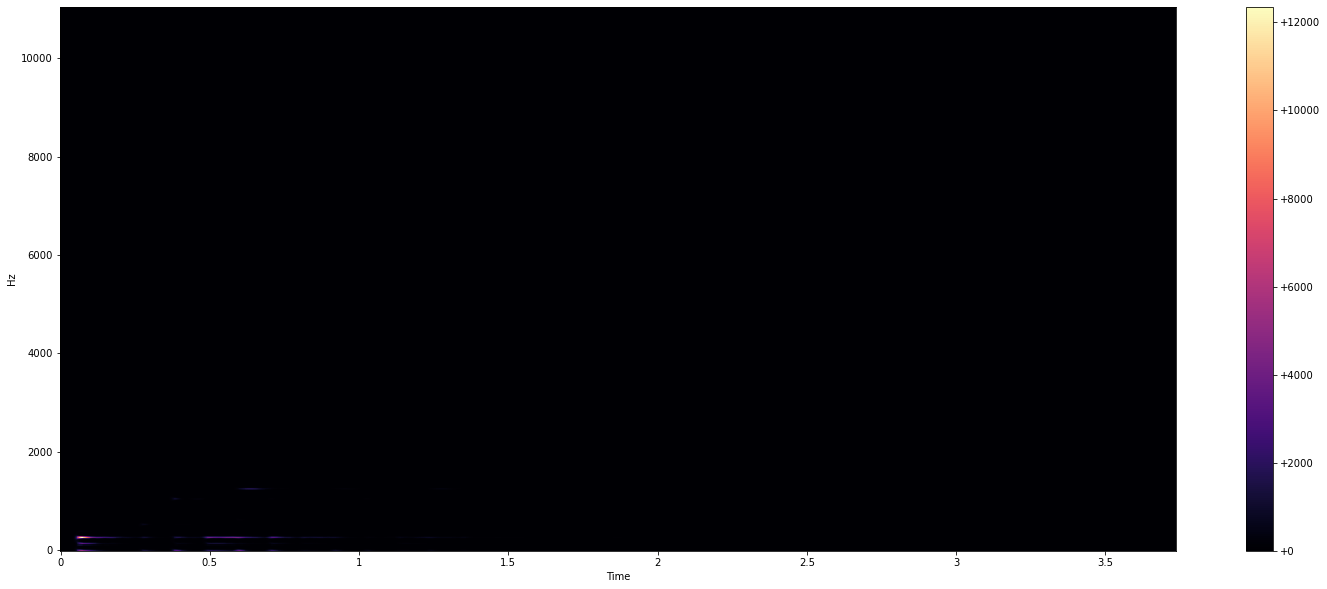

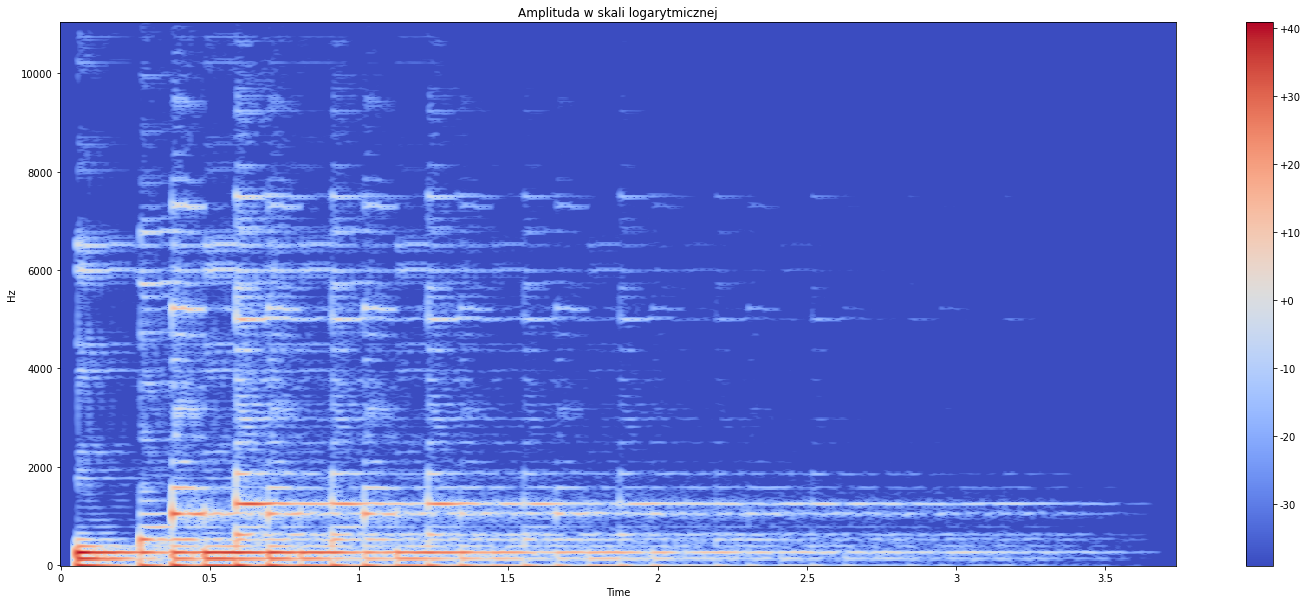

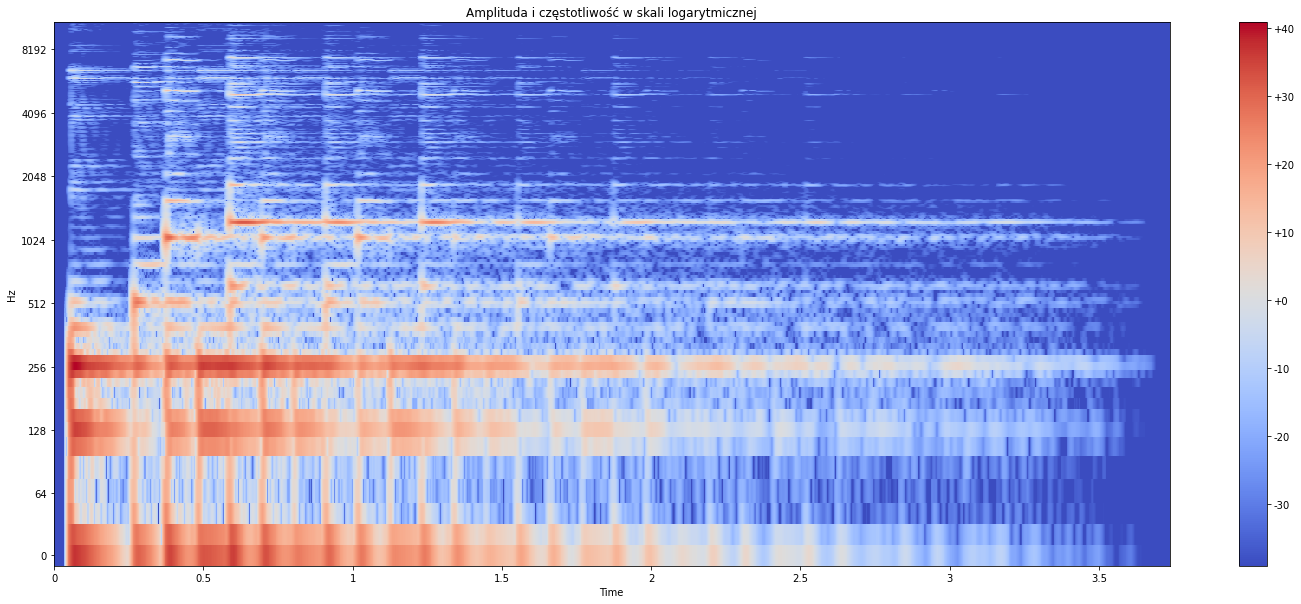

In [290]:
wtype = int(input("wybierz rodzaj ramki [1 - prostokątne, 2 - Hamminga, 3 - Hanna]: "))
fchosen = int(input("wybierz długość ramki: "))
hchosen = int(input("wybierz długość skoku okna (frame-overlap): "))

spec_plot(signal, WindowType(wtype), fchosen, hchosen)
spec_plot(signal, WindowType(wtype), fchosen, hchosen, logAmp=True, title='Amplituda w skali logarytmicznej')
spec_plot(signal, WindowType(wtype), fchosen, hchosen, y_axis="log", logAmp=True, title='Amplituda i częstotliwość w skali logarytmicznej')

## 5. Wykresy parametrów
Wyznaczenie i rysowanie wykresów parametrów dźwięku z dziedziny
częstotliwości.

### Volume

In [291]:
def Vol(signal):
    vol = []
    S = librosa.stft(signal, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
    Y = (np.abs(S) ** 2).T
    for frame in Y:
        v = frame.sum()/FRAME_SIZE
        vol.append(v)
    return np.array(vol)

def Vol_plot(signal):
    vol = Vol(signal)
    frames = range(len(vol))
    t = librosa.frames_to_time(frames, hop_length=HOP_SIZE)
    
    plt.figure(figsize=(18,8))
    plt.plot(t, vol, color='m')
    plt.title("Volume")

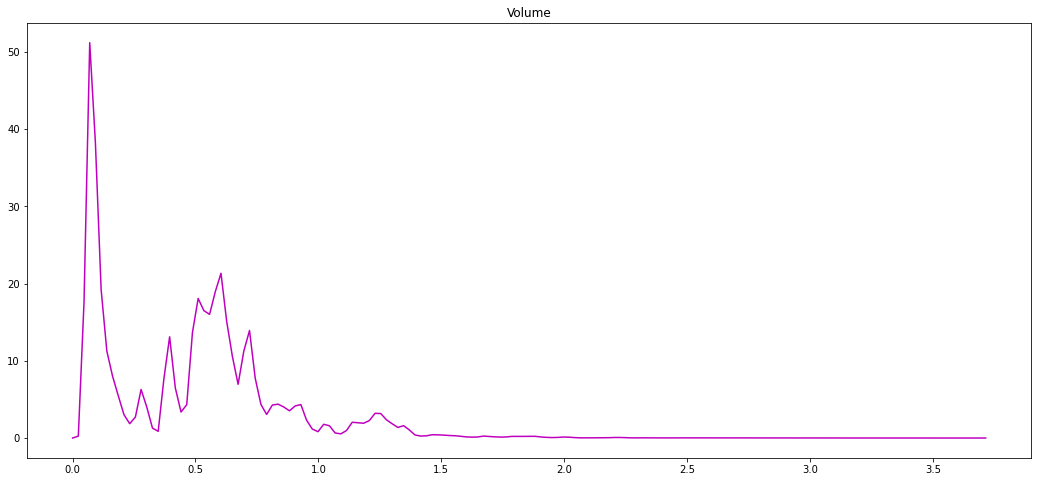

In [292]:
Vol_plot(signal)

### Frequency/spectral centroid (FC/SC)

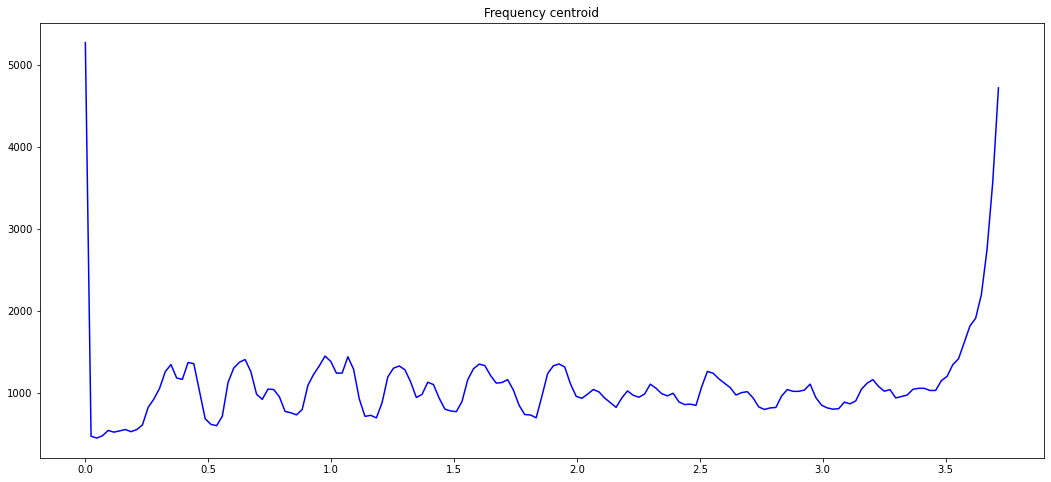

In [293]:
sc = librosa.feature.spectral_centroid(y=signal, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)[0]
frames = range(len(sc))
t = librosa.frames_to_time(frames, hop_length=HOP_SIZE)
plt.figure(figsize=(18,8))
plt.plot(t,sc,color='b')
plt.title("Frequency centroid")
plt.show()

### Effective Bandwidth (BW)

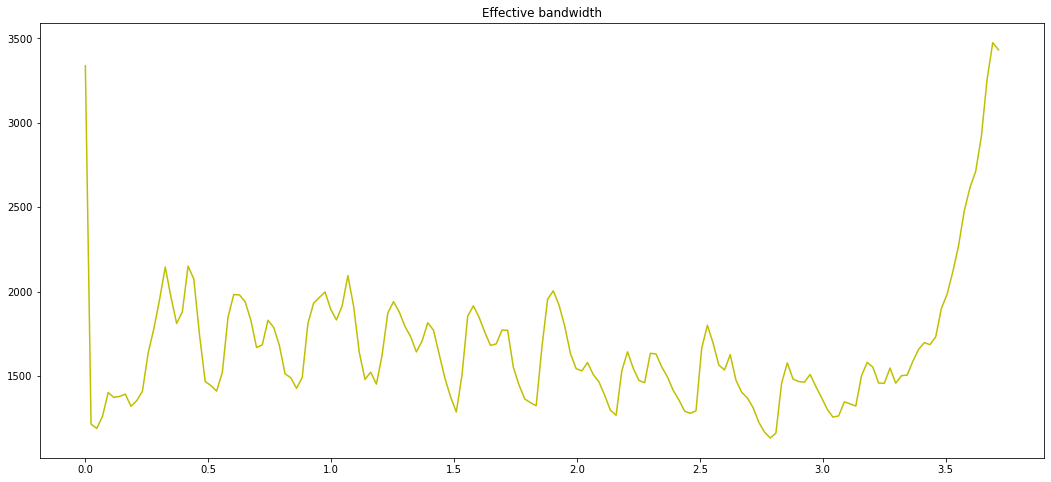

In [294]:
sb = librosa.feature.spectral_bandwidth(y=signal,sr=sr,n_fft=FRAME_SIZE,hop_length=HOP_SIZE)[0]
plt.figure(figsize=(18,8))
plt.plot(t,sb,color='y')
plt.title("Effective bandwidth")
plt.show()

### Band Energy (BE), Band Enery Ratio (BER)

In [295]:
def split_fbin(splitF, sr, fbin_num):
    fRange = sr/2
    fPerBin = fRange/fbin_num
    splitFBin = math.floor(splitF/fPerBin)
    return int(splitFBin)

def BER(spec, splitF, sr):
    ber = []
    F = split_fbin(splitF, sr, len(spec[0]))
    Y = (np.abs(spec) ** 2).T
    for frame in Y:
        low = frame[:F].sum()
        high = frame[F:].sum()
        curr_ber = low / high
        ber.append(curr_ber)
    return np.array(ber)

def BER_plot(signal, splitF, sr=sr):
    S = librosa.stft(signal, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
    ber = BER(S, splitF, sr)
    frames = range(len(ber))
    t = librosa.frames_to_time(frames, hop_length=HOP_SIZE)
    
    plt.figure(figsize=(18,8))
    plt.plot(t, ber, color='r')
    plt.title("Band Energy Ratio")

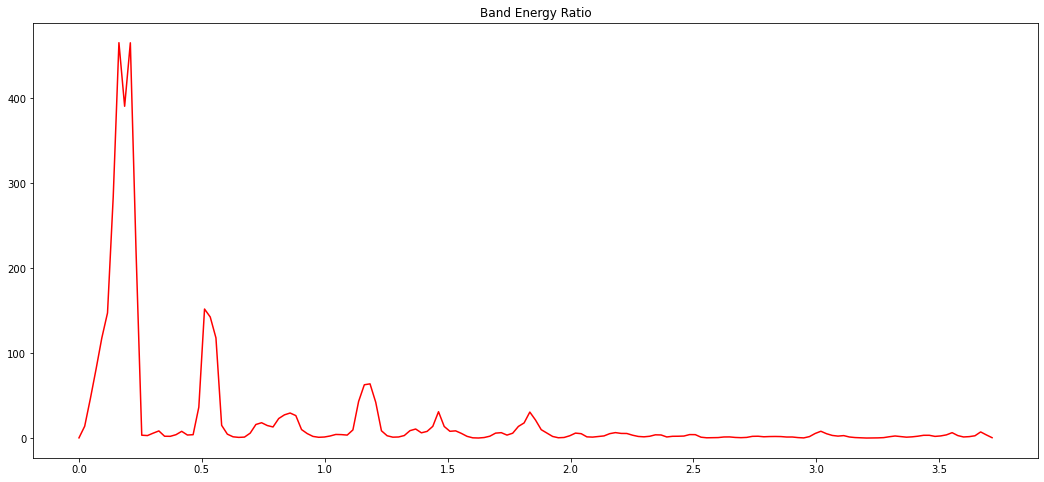

In [296]:
splitF = 2000
BER_plot(signal, splitF)

### Spectral Flatness Measure (SFM)


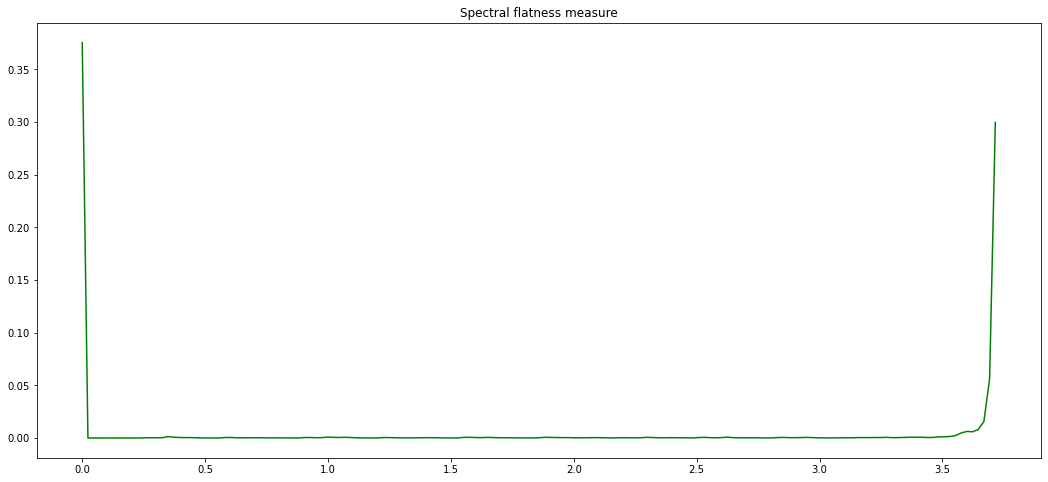

In [297]:
sf = librosa.feature.spectral_flatness(y=signal,n_fft=FRAME_SIZE,hop_length=HOP_SIZE)[0]
plt.figure(figsize=(18,8))
plt.plot(t,sf,color='g')
plt.title("Spectral flatness measure")
plt.show()

## Porównanie

In [298]:
abeA = "./audio/speakerA/abe.wav"
rosA = "./audio/speakerA/rosomak.wav"
zerA = "./audio/speakerA/zero.wav"
sAbeA, sr = librosa.load(abeA)
sRosA, _ = librosa.load(rosA)
sZerA, _ = librosa.load(zerA)

abeB = "./audio/speakerB/abe.wav"
rosB = "./audio/speakerB/rosomak.wav"
zerB = "./audio/speakerB/zero.wav"
sAbeB, _ = librosa.load(abeB)
sRosB, _ = librosa.load(rosB)
sZerB, _ = librosa.load(zerB)

phones = ["i","u","a","s","d","b"]
dirpart = "./audio/speaker"
speakerA = [librosa.load(f"{dirpart}A/{ph}.wav")[0] for ph in phones]
speakerB = [librosa.load(f"{dirpart}B/{ph}.wav")[0] for ph in phones]

In [299]:
# Vol
def FC(signal):
    return librosa.feature.spectral_centroid(y=signal, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)[0]
def BW(signal):
    return librosa.feature.spectral_bandwidth(y=signal,sr=sr,n_fft=FRAME_SIZE,hop_length=HOP_SIZE)[0]
# BER
def SFM(signal):
    return librosa.feature.spectral_flatness(y=signal,n_fft=FRAME_SIZE,hop_length=HOP_SIZE)[0]

def F0(signal):
    sig_to_frames = librosa.util.frame(signal,frame_length=FRAME_SIZE, hop_length=HOP_SIZE)
    frame_len,frame_num = sig_to_frames.shape
    peaks = []
    for i in range(frame_num):
        frame = sig_to_frames[:,i]
        freq = np.fft.fftfreq(frame_len,1/sr)
        m = magn(frame)
        mid = math.ceil(frame_len//2)
        magn_max_id = np.argmax(m[:mid])
        peaks.append(freq[magn_max_id])
    return peaks

In [300]:
rows = 10
cols = 4
def compPair(signal1,signal2,handle,box,label,titles=[],rows=rows,cols=cols):
    par1 = handle(signal1)
    par2 = handle(signal2)
    t1 = librosa.frames_to_time(range(len(par1)), hop_length=HOP_SIZE)
    t2 = librosa.frames_to_time(range(len(par2)), hop_length=HOP_SIZE)
    maxpar = max(max(par1),max(par2))
    
    plt.subplot(rows,cols,box)
    if titles!=[]:
        plt.title(titles[0])
    plt.plot(t1, par1, color='tab:blue')
    plt.ylim((0,maxpar))
    if label!="": plt.ylabel(label)
    
    plt.subplot(rows,cols,box+1)
    if titles!=[]:
        plt.title(titles[1])
    plt.plot(t2, par2, color='tab:pink')
    plt.ylim((0,maxpar))

In [301]:
def compParams(signal1, signal2, splitF, titles=[], i=1):
    start = i
    compPair(signal1,signal2,Vol,i,"Volume" if start==1 else "",titles)
    i+=4
    compPair(signal1,signal2,FC,i,"Frequency centroid" if start==1 else "")
    i+=4
    compPair(signal1,signal2,BW,i,"Effective bandwidth" if start==1 else "")
    i+=4
    compPair(signal1,signal2,SFM,i,"Spectral flatness measure" if start==1 else "")
    i+=4
    
    # BER
    S1 = librosa.stft(signal1, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
    ber1 = BER(S1, splitF, sr)
    t1 = librosa.frames_to_time(range(len(ber1)), hop_length=HOP_SIZE)
    
    S2 = librosa.stft(signal2, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
    ber2 = BER(S2, splitF, sr)
    t2 = librosa.frames_to_time(range(len(ber2)), hop_length=HOP_SIZE)
    
    maxber = max(max(ber1),max(ber2))
    
    plt.subplot(rows,cols,i)
    i+=1
    if start==1: plt.ylabel("Band Energy Ratio")
    plt.plot(t1, ber1, color='tab:blue')
    plt.ylim((0,maxber))
    plt.subplot(rows,cols,i)
    plt.plot(t2, ber2, color='tab:pink')
    plt.ylim((0,maxber))

### Parametry dla różnych głosek i głosów

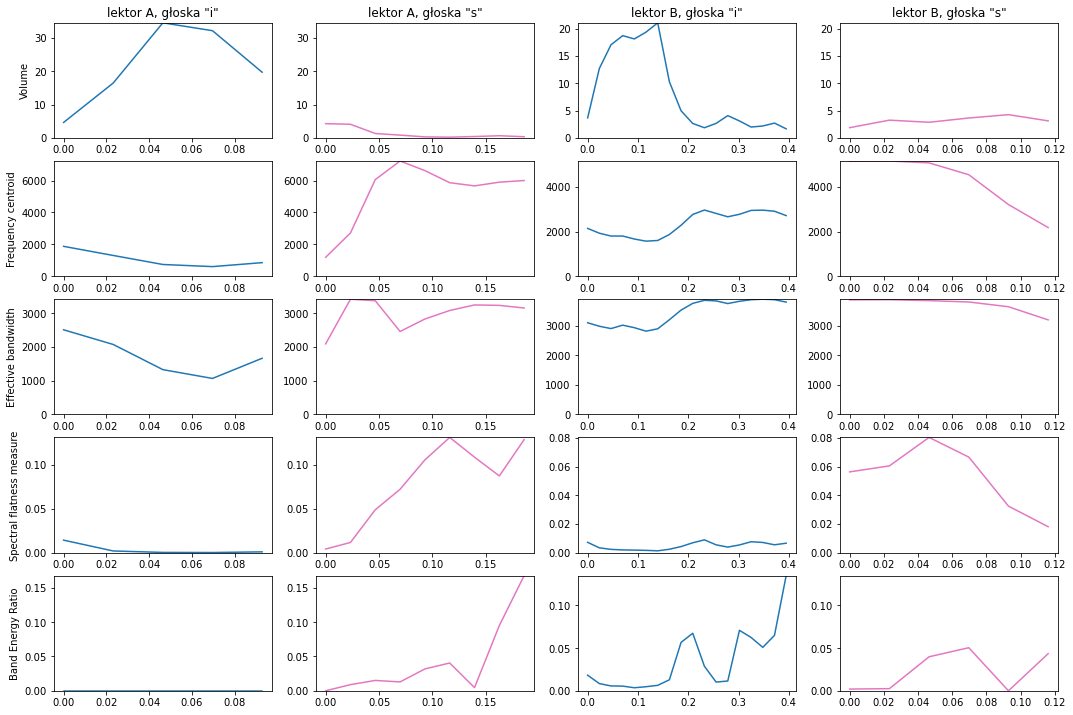

In [302]:
plt.figure(figsize=(18,25))
compParams(speakerA[0],speakerA[3],2000,['lektor A, głoska "i"','lektor A, głoska "s"'])
compParams(speakerB[0],speakerB[3],2000,['lektor B, głoska "i"','lektor B, głoska "s"'],i=3)
plt.show()

### Zmiana tonu podstawowego (u jednego mówcy / różnych)

In [303]:
def compF0(sAbeA,sZerA,sRosA,ind,speaker):
    abeAF0 = F0(sAbeA)
    zerAF0 = F0(sZerA)
    rosAF0 = F0(sRosA)

    plt.subplot(3,2,ind)
    plt.plot(abeAF0,color='tab:orange')
    plt.legend(["abe"], loc="center")
    plt.title(f"Speaker {speaker}")

    plt.subplot(3,2,ind+2)
    plt.plot(zerAF0,color='tab:green')
    plt.legend(["zero"], loc="center")
    plt.ylabel("F0 [Hz]")

    plt.subplot(3,2,ind+4)
    plt.plot(rosAF0,color='tab:purple')
    plt.legend(["rosomak"], loc="center")

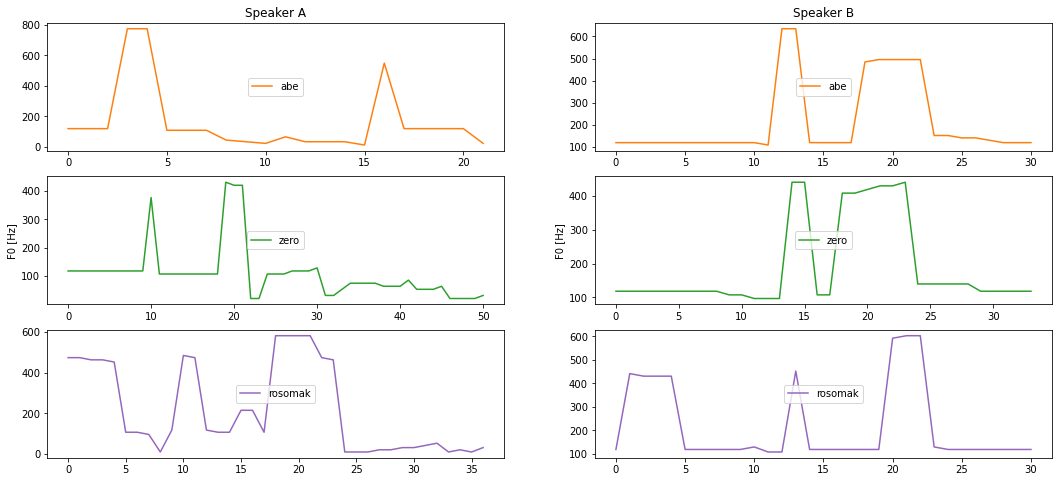

In [304]:
plt.figure(figsize=(18,8))
compF0(sAbeA,sZerA,sRosA,1,'A')
compF0(sAbeB,sZerB,sRosB,2,'B')
plt.show()

### Różnice w  spektogramie
#### Zaznaczone formanty F1 F2 dla samogłosek

In [305]:
rows = 2
cols = 3
def compSpecto(signal, ind, frame_type, frame_length, hop_length, y_axis="linear", title="", sr=sr, logAmp=False, f1=-1, f2=-1):
    
    if frame_type == WindowType.HANN:
        S = librosa.stft(signal, n_fft=frame_length, window = sp.signal.windows.hann,  hop_length=hop_length)
    elif frame_type == WindowType.HAMM:
        S = librosa.stft(signal, n_fft=frame_length, window = sp.signal.windows.hamming,  hop_length=hop_length)
    else:
        S = librosa.stft(signal, n_fft=frame_length, window = np.ones(frame_length) , hop_length=hop_length)
    
    Y = np.abs(S)**2
    if logAmp:
        Y =librosa.power_to_db(Y)
        
    plt.subplot(rows,cols,ind)
    
    librosa.display.specshow(Y, 
                             sr=sr, 
                             hop_length=hop_length, 
                             x_axis="time", 
                             y_axis=y_axis)
    plt.colorbar(format="%+2.f")
    if f1>=0 and f2>=0: 
        plt.axhline(f1,linewidth=4, color='k', label="F1")
        plt.axhline(f2,linewidth=4, color='g', label="F2")
        plt.legend()
    plt.title(title)

In [306]:
fchosen = 512
hchosen = 64
def spectoForSpeaker(sp, n=6, f1=[240,250,850], f2=[2400,595,1610]):
    plt.figure(figsize=(25,10))
    speaker = speakerA if sp=="A" else speakerB
    for i in range(0,n):
        sig = speaker[i]
        ph = phones[i]
        if i<3: compSpecto(sig, i+1, WindowType(3), fchosen, hchosen, y_axis="log", logAmp=True, title=f"głoska '{ph}'", f1=f1[i],f2=f2[i])
        else: compSpecto(sig, i+1, WindowType(3), fchosen, hchosen, y_axis="log", logAmp=True, title=f"głoska '{ph}'") 
    plt.suptitle(f"Dla lektora {sp}",fontsize=25)
    plt.show()

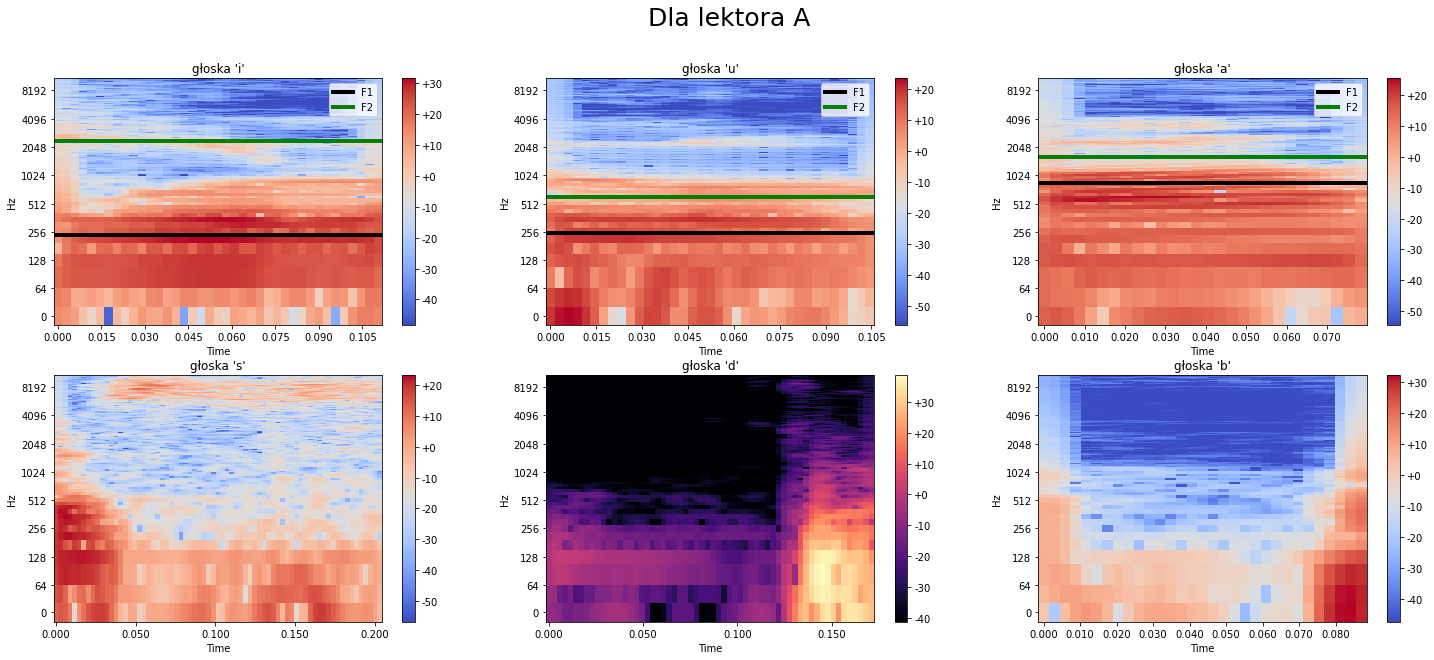

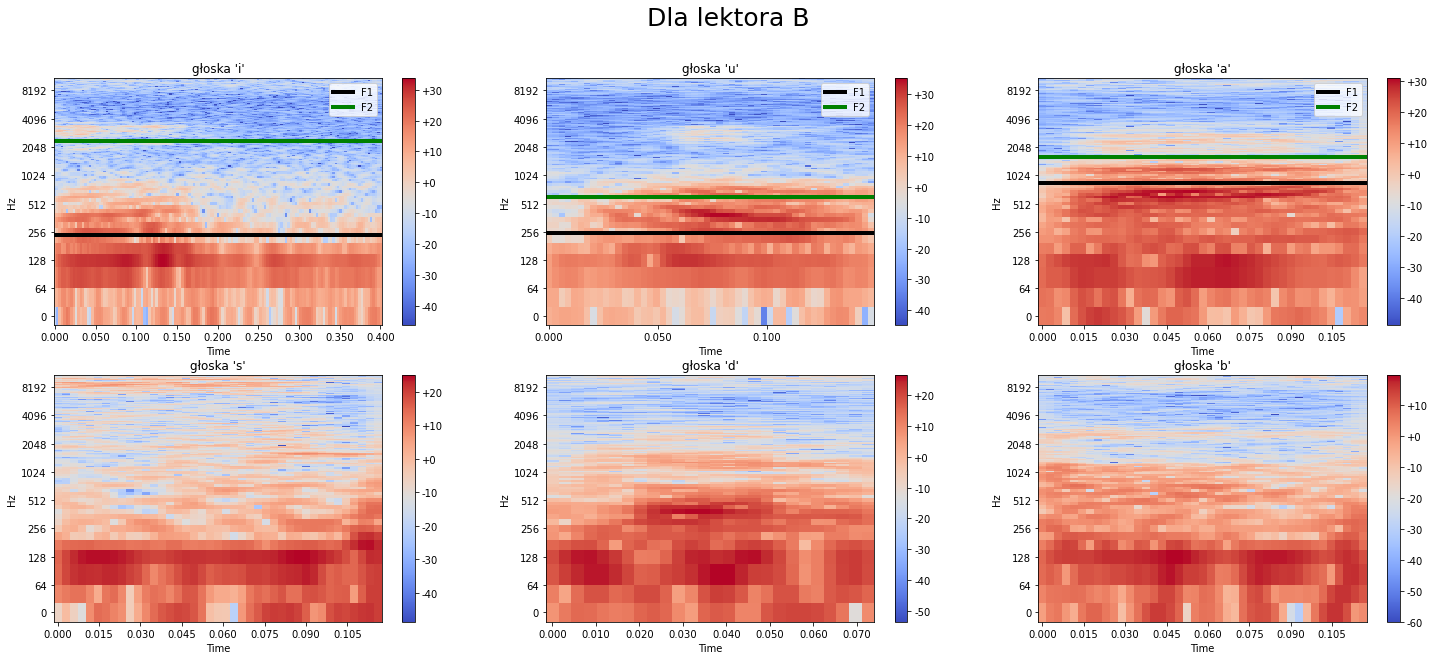

In [307]:
spectoForSpeaker("A")
spectoForSpeaker("B")

### Różnice w widmie

In [308]:
def compSpectr(sp,n=6,speaker=[]):
    plt.figure(figsize=(25,10))
    if sp=="A": speaker = speakerA 
    elif sp=="B": speaker = speakerB
    else: speaker = speaker
    color = iter(cm.rainbow(np.linspace(0, 1, n)))
    for i in range(0,n):
        sig = speaker[i]
        ph = phones[i]
        plt.subplot(rows,cols,i+1)
        plotSpectr(sig,sr,f"głoska '{ph}'",color=next(color),showAxes=False)
    plt.suptitle(f"Dla lektora {sp}",fontsize=25)
    plt.show()

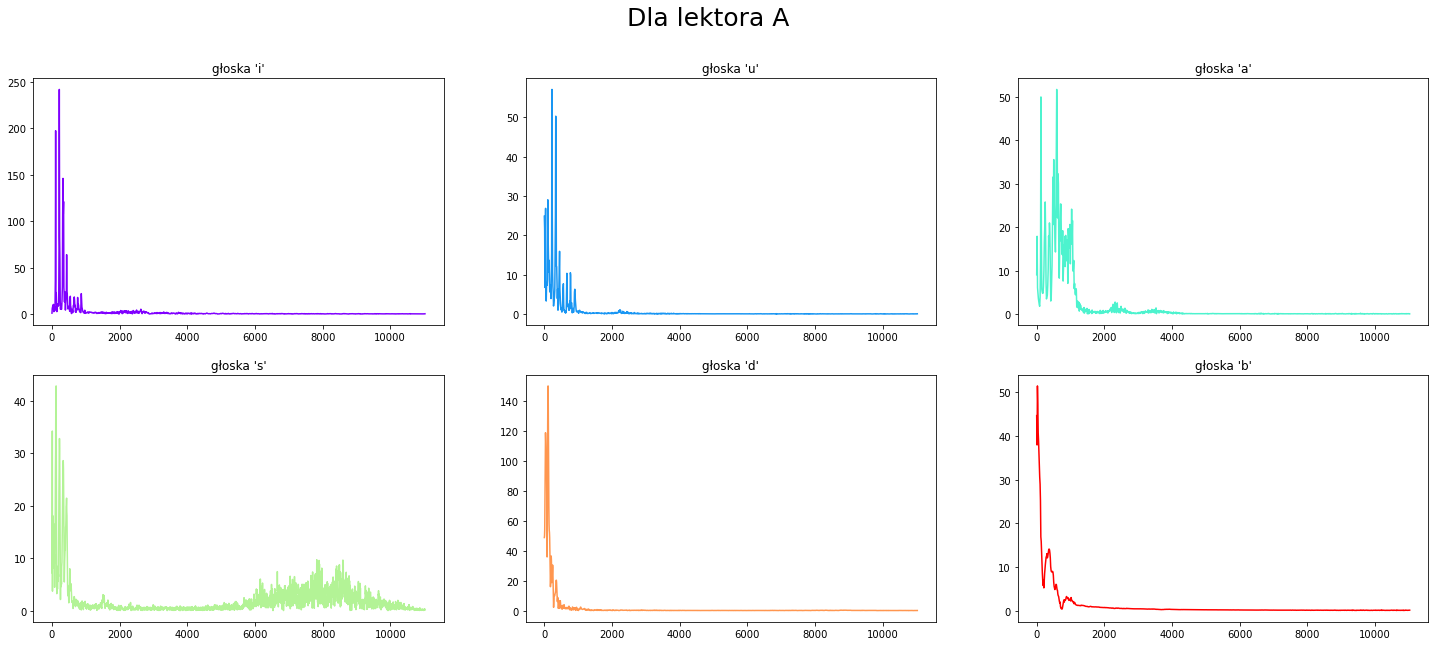

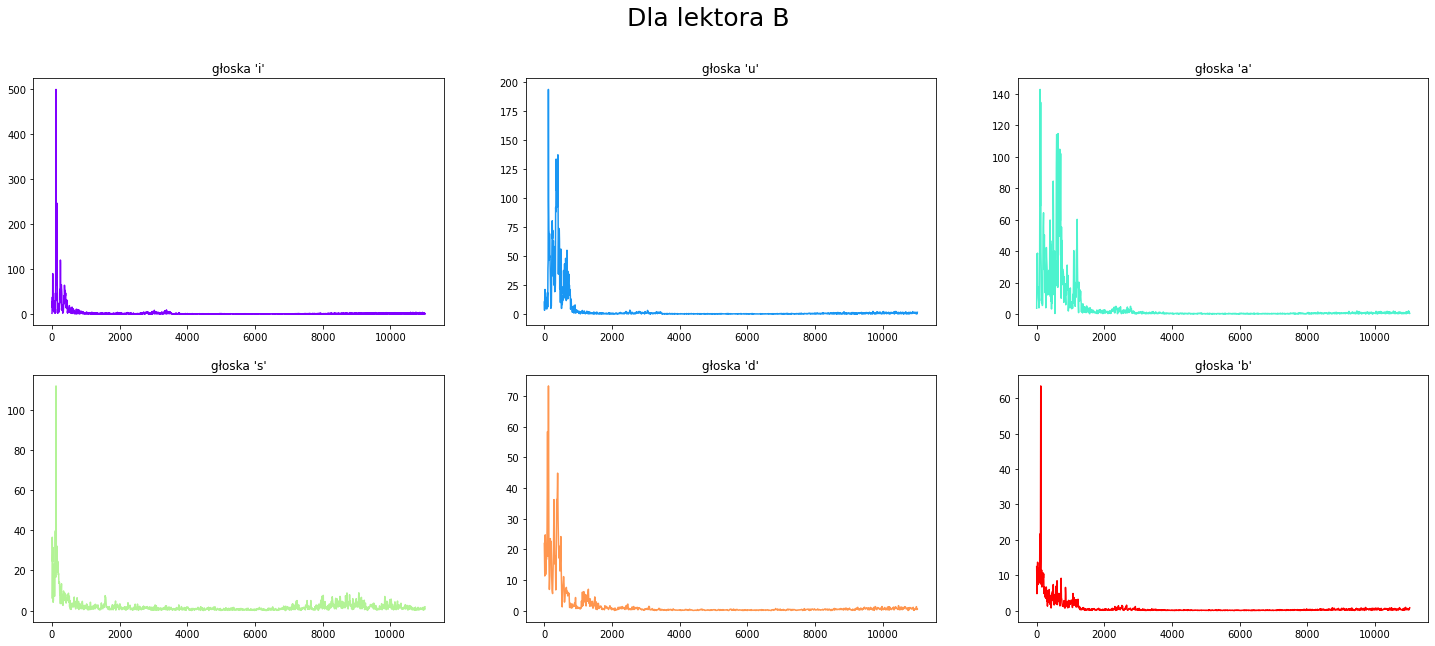

In [309]:
compSpectr("A")
compSpectr("B")

### Realizacje jednego fonemu

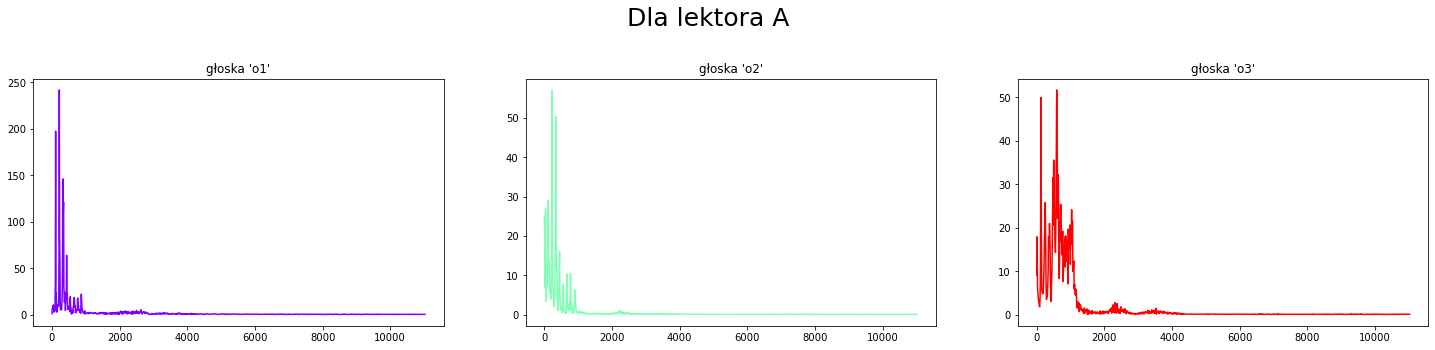

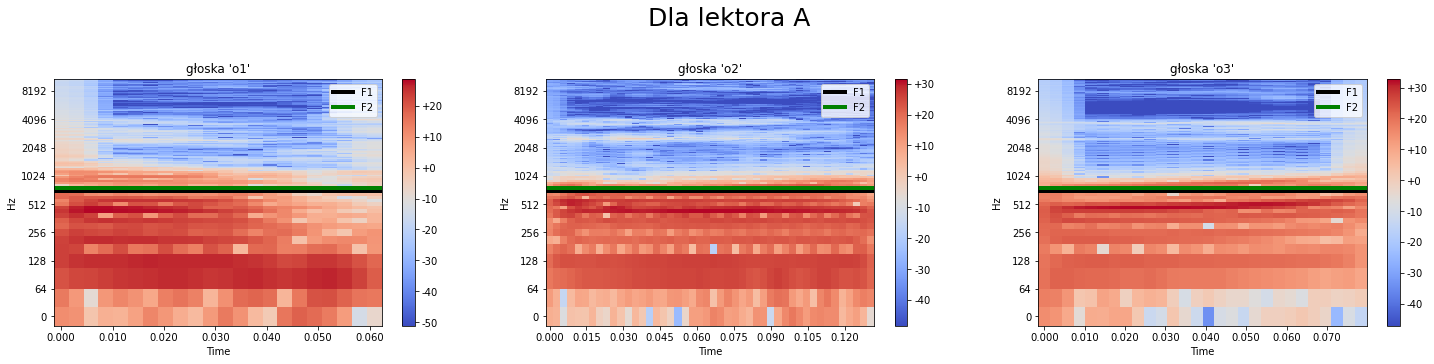

In [310]:
phones = ["o1", "o2", "o3"]
dirpart = "./audio/speaker"
speaker = [librosa.load(f"{dirpart}A/{ph}.wav")[0] for ph in phones]
compSpectr("A",n=3,speaker=speaker)
speakerA = speaker
f1 = [700 for i in range(3)]
f2 = [760 for i in range(3)]
spectoForSpeaker("A",n=3,f1=f1,f2=f2)